# Applying fairnes metrics on the CelebA dataset

<a href="https://colab.research.google.com/drive/1F9qxGqZ_vydHEK8w_x6MlFONKtoAoQM4" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
</a>

Return to the [Castle](https://github.com/Nkluge-correa/TeenyTinyCastle)

Machine Learning Fairness is an area of research that focuses on ensuring that machine learning algorithms are fair and unbiased, while also trying to undestrand the many ways in wich such systems can discriminate. Addressing algorithmic biases is a crucial issue in ML, given that machine learning models are increasingly used in fields where their decisions can impact people's lives, such as finance, employment, and criminal justice.

<img src="https://miro.medium.com/max/1060/1*cc8OWxqKFXje4d_1eYrQkg.jpeg" width="600"/>

Source: [Moritz Hardt](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb/).

In this notebook, we will take a look at the [Celeb Faces Attributes](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/) dataset (`CelebA`). `CelebA` contains 202,599 face images of size 178×218 from 10,177 celebrities, each annotated with 40 binary labels, indicating facial attributes like hair color, gender, and age. Here, we will train a CNN model based on the [LeNet5](https://en.wikipedia.org/wiki/LeNet) architecture.

> **Note: `LeNet5` is a CNN introduced by Yann LeCun in 1989. It is one of the first Deep Learning models to recognize handwritten characters and digits.**

We will train our `CNN` in a binary classification task using the `Smiling` attribute as a target, i.e., we are making a smile detector.

After that, we will check if our model has a bias against the sensitive attribute `[age]`.

> **Note: all datasets and models related to the course and repo are in the Hub🤗. Also, the dataset we will be using is only a subset of the original CelebA dataset, with 50K images (25K smiling, 25K not smiling).**



In [1]:
!pip install datasets -q
from datasets import load_dataset

# load the datasets from the hub
dataset = load_dataset('AiresPucrs/CelebA-Smiles', split="train")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Before starting our training, let us perform some pre-processing. CelebA images are 178 X 218 in size. To lower the computational cost of training our model, we will resize them to 100 X 100 pixels.

In [2]:
# Resize images (100 x 100)
def resize_image(examples):
    examples["resized_image"] = [image.convert("RGB").resize((100,100)) for image in examples["image"]]
    return examples

# Apply `resize_image` funtion to the dataset
dataset = dataset.map(resize_image, batched=True)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Also, we will store our images in a local folder and create a new data frame where we will keep their respective paths (path to the pictures) and attributes of interest, i.e., our labels (`Smiling`) and sensitive characteristics of interest (`Young`).

In [3]:
import pandas as pd
import numpy as np
import tqdm
import os

# Create a folder to store the CelebA images
os.makedirs('celebA_images', exist_ok=True)

# Select the features we will use for this tutorial
labels = [1 if x > 0 else 0 for x in dataset['Smiling']] # 1 = smiling
sensitive_attribute = [1 if x > 0 else 0 for x in dataset['Young']] # 1 = young
image_path = []

# Iterate over the dataset, save images and their respective paths
for i in tqdm.tqdm(range(len(dataset))):
  dataset[i]['resized_image'].save(f"./celebA_images/{i}.png")
  image_path.append(f"./celebA_images/{i}.png")

# Create a new dataframe with all these features
dataset_df = pd.DataFrame({
    "image_path": image_path,
    "labels": labels,
    "sensitive_attribute": sensitive_attribute
})

display(dataset_df)

100%|██████████| 50000/50000 [03:06<00:00, 268.77it/s]


,image_path,labels,sensitive_attribute
0,./celebA_images/0.png,1,1
1,./celebA_images/1.png,0,1
2,./celebA_images/2.png,0,1
3,./celebA_images/3.png,0,1
4,./celebA_images/4.png,1,1
...,...,...,...
49995,./celebA_images/49995.png,0,1
49996,./celebA_images/49996.png,1,1
49997,./celebA_images/49997.png,1,1
49998,./celebA_images/49998.png,1,1


Using our new data frame, we can plot the distribution of our sensitive attribute. Then, we will see that the population of `young` samples dominates the dataset, regardless of the value of our label feature.

In [4]:
import plotly.graph_objects as go

not_smiling = []
smiling = []

for element in list(dataset_df['sensitive_attribute'].unique()):
    temp_df = dataset_df[dataset_df['sensitive_attribute'] == element]['labels'].value_counts()
    temp_df.sort_index(inplace=True)
    not_smiling.append(temp_df.iloc[0])
    smiling.append(temp_df.iloc[1])

fig = go.Figure(data=[
    go.Bar(name='Smiling', x=[1, 0], y=smiling),
    go.Bar(name='Not Smiling', x=[1, 0], y=not_smiling)
])

fig.update_layout(
    barmode='group',
    template='plotly_dark',
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['Not Young', 'Young']
    ),
    xaxis_title="<b>Age</b>",
    yaxis_title="<b>Smiling</b>",
    title='Distribution of <i>Smiling People</i> by "Age"',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    plot_bgcolor='rgba(0, 0, 0, 0)',
)
fig.show()


Now, we need to split our dataset to train, validate, and verify the performance of our model. we will use `train_test_split` from `scikit-learn.`

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_df, test_df = train_test_split(dataset_df, test_size=0.1, random_state=42, stratify=dataset_df['labels'])

# Split the train set into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['labels'])

Now, we will create a wrapper around our three data frames to make them a generator that produces batches of images and labels. We are using the `torch.utils.data.Dataset` for this.

In [6]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

# Transforms image inputs into tensors
transform = transforms.ToTensor()

class Dataset(Dataset):
    def __init__(self, dataset):

        self.data = dataset
        self.transform = transform

    def __len__(self):

        return len(self.data)

    def __getitem__(self, index):

        # Retrive images
        image_path = self.data['image_path'].iloc[index]
        images = Image.open(image_path)
        images = self.transform(images)

        # Retrive labels
        labels = self.data['labels'].iloc[index]

        return images, labels

train_data  = Dataset(train_df)
val_data  = Dataset(val_df)
test_data  = Dataset(test_df)


print('Train dataset size:', len(train_data))
print('Test dataset size:', len(test_data))
print('Validation dataset size:', len(val_data))

Train dataset size: 40500
Test dataset size: 5000
Validation dataset size: 4500


Now that we have a working dataset, let us look into some samples from our smiley version of the `CelebA` dataset.

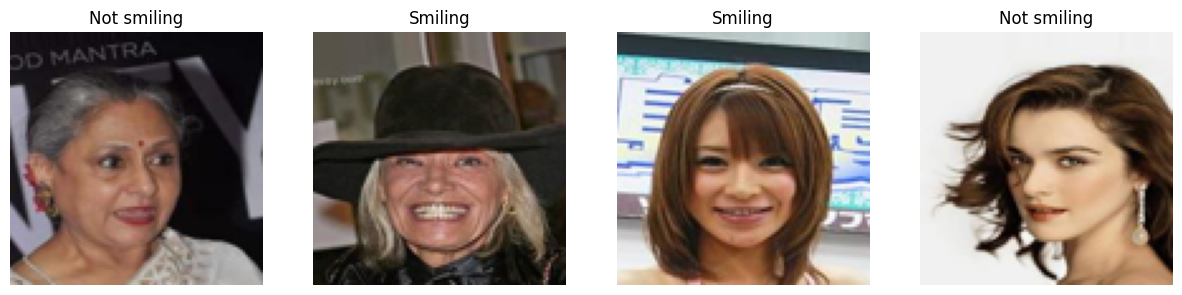

In [7]:
import matplotlib.pyplot as plt
import random
import numpy as np

plt.figure(figsize=(15,15))

for i in range(4):

    # Get a random sample
    random_sample = random.randint(0, len(train_data)-1)

    # Get the image and its corresponding label
    image, label = train_data.__getitem__(random_sample)

    # Plot the sample
    plt.subplot(1,4,i+1)
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title('Smiling' if label == 1 else 'Not smiling')

plt.show()


To train a model, we will use PyTorch to implement a simplified version of the `LeNet5` network (`LeNNon`). If you are still getting familiar with PyTorch, check out our [`Machine Learning Intro Course`](https://github.com/Nkluge-correa/TeenyTinyCastle/tree/master/ML-Intro-Course) or the [Pytorch tutorials](https://pytorch.org/tutorials/) section.

In [12]:
import torch.nn as nn

class LeNNon(nn.Module):
    def __init__(self):
        """ Define a CNN architecture used for image classification.
            This class defines the LeNNon architecture as a PyTorch module
        """
        super(LeNNon, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 25 * 25, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        """
        Perform a forward pass through the LeNNon architecture.

        This method applies the convolutional layers, max pooling layers,
        and fully connected layers to the input tensor x.

        Parameters:
        -----------
        x (torch.Tensor): The input tensor.

        Returns:
        --------
        torch.Tensor: The output tensor.
        """
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 25 * 25)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNNon()

model = model.to(device)

display(model)

LeNNon(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=20000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Below, we will create dataloaders (`torch.utils.data.DataLoader`) for our datasets/generators, setting the batch size to 256. You should be able to run this training with almost any GPU with more than 2GB of VRAM.

> **Note: there is no need to shuffle the data used in validation or testing!**

In [13]:
batch_size = 256

trainLoader = torch.utils.data.DataLoader(train_data,batch_size=batch_size, shuffle=True)
testLoader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
valLoader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

If everything was done accordingly, our CNN should train smoothly. If you do not wish to train this model, download our pre-trained model from the Hub! Ignore the cell below if you want to train your own model. 😎

In [10]:
!git lfs install
!git clone https://huggingface.co/AiresPucrs/LeNNon-Smile-Detector

Git LFS initialized.
Cloning into 'LeNNon-Smile-Detector'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 18 (delta 6), reused 0 (delta 0), pack-reused 6
Unpacking objects: 100% (18/18), 2.58 KiB | 879.00 KiB/s, done.


In [14]:
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_acc = 0
    model.train()

    with tqdm(total=len(trainLoader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for images, labels in trainLoader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_acc += (predicted == labels).sum().item()

            pbar.update(1)

        pbar.set_postfix({'Train Loss': train_loss / len(trainLoader), 'Train Acc': train_acc / len(trainLoader.dataset)})

    # Validation
    val_loss = 0
    val_acc = 0
    model.eval()
    with torch.no_grad():
        for images, labels in valLoader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_acc += (predicted == labels).sum().item()

    val_loss /= len(valLoader)
    val_acc /= len(valLoader.dataset)

print(f'Final Validation Accuracy: ' + '{:.2f}' .format(100 * val_acc)+'%', 'Final Validation Loss: ' + '{:.4f}'.format(val_loss))
torch.save(model, 'LeNNon-Smile-Detector.pt')


Epoch 5/20: 100%|██████████| 159/159 [00:43<00:00,  3.68batch/s, Train Loss=0.208, Train Acc=0.915]


Epoch [5/20], Train Loss: 0.2076, Train Acc: 37051.0000, Val Loss: 0.2243, Val Acc: 0.9084


Epoch 10/20: 100%|██████████| 159/159 [00:43<00:00,  3.63batch/s, Train Loss=0.171, Train Acc=0.93]


Epoch [10/20], Train Loss: 0.1708, Train Acc: 37667.0000, Val Loss: 0.2182, Val Acc: 0.9153


Epoch 15/20: 100%|██████████| 159/159 [00:44<00:00,  3.61batch/s, Train Loss=0.117, Train Acc=0.953]


Epoch [15/20], Train Loss: 0.1170, Train Acc: 38605.0000, Val Loss: 0.2457, Val Acc: 0.9118


Epoch 20/20: 100%|██████████| 159/159 [00:43<00:00,  3.64batch/s, Train Loss=0.0506, Train Acc=0.982]


Epoch [20/20], Train Loss: 0.0506, Train Acc: 39759.0000, Val Loss: 0.3589, Val Acc: 0.9082
Final Validation Accuracy: 90.82% Final Validation Loss: 0.3589


Now, let us load our trained model and evaluate it on the testing portion of our split.


In [25]:
from sklearn.metrics import confusion_matrix
import plotly.express as px

# If you cloned the model from the Hub and skipped training
# use `./LeNNon-Smile-Detector/LeNNon-Smile-Detector.pt` as your path
model = torch.load('./LeNNon-Smile-Detector.pt')
model = model.to(device)
model.eval()

correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for data in tqdm(testLoader, total=len(testLoader)):
        images, labels = data
        # if you are not using GPU, you can remove this next line
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

print('\nAccuracy on the test images: %d %%' % (100 * correct / total))

# Create the confusion matrix
matrix_test = confusion_matrix(true_labels, predicted_labels)

fig = px.imshow(matrix_test,
                labels=dict(x="Predicted", y="True label"),
                x=['Smiling', 'Not Smiling'],
                y=['Smiling', 'Not Smiling'],
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

100%|██████████| 20/20 [00:04<00:00,  4.26it/s]


Accuracy on the test images: 97 %


To further evaluate our model, let us plot the images together with their corresponding labels and predictions. By doing so, we can visually inspect the model's performance.

> **Note: 1 = `smiling` and 0 = `not_smiling`.**

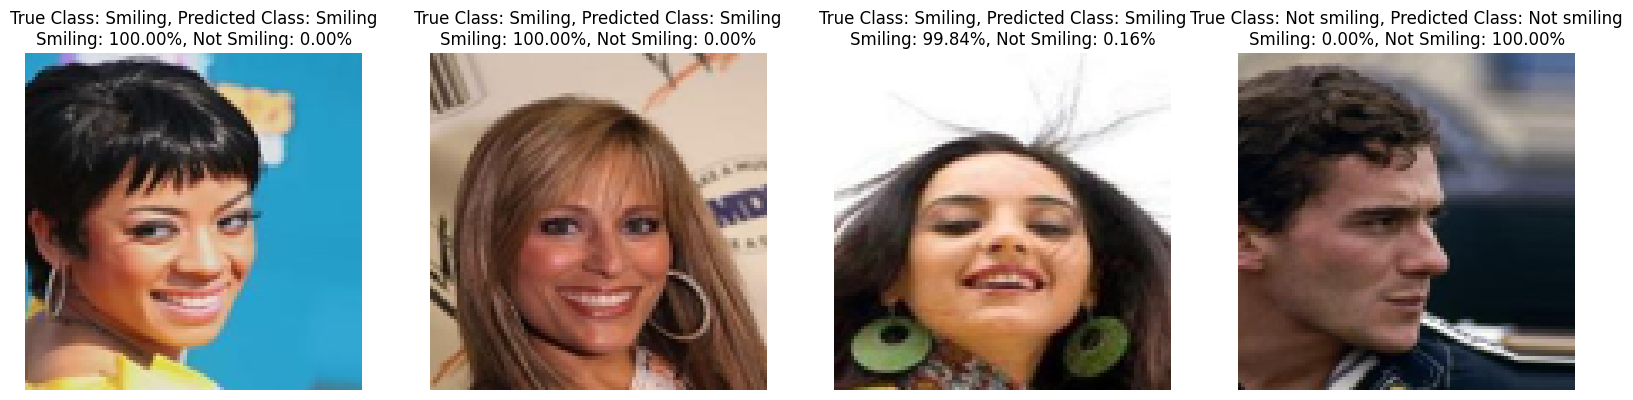

In [30]:
import random
import matplotlib.pyplot as plt

# Select a random subset of images to plot
subset_indices = random.sample(range(len(test_df)), 4)

plt.figure(figsize=(20, 20))

for i, idx in enumerate(subset_indices):
    # Load and preprocess the image
    image_path = test_df['image_path'].iloc[idx]
    image = Image.open(image_path)
    tensor = transform(image).unsqueeze(0)
    # if you are not using GPU, you can remove this next line
    tensor = tensor.cuda()

    # Make a prediction
    with torch.no_grad():
        output = model(tensor)

    # Apply softmax to get probabilities
    probabilities = torch.softmax(output, dim=1)
    percent_smiling = probabilities[0][1].item() * 100
    percent_not_smiling = probabilities[0][0].item() * 100

    # Extract the predicted class
    _, predicted = torch.max(output.data, 1)

    # Plot the samples
    plt.subplot(1, 4, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('True Class: {}, Predicted Class: {}\nSmiling: {:.2f}%, Not Smiling: {:.2f}%'.format(
        'Smiling' if test_df.iloc[idx]['labels'] == 1 else 'Not smiling',
        'Smiling' if predicted.item() == 1 else 'Not smiling',
        percent_smiling,
        percent_not_smiling
    ))

plt.show()


Now, let us evaluate our model's performance on two groups of people with different sensitive attributes: **_age_**. We want to measure any disparities in treatment or model output for these groups. To do this, we can use statistical metrics of fairness. These metrics can help us identify any unfair treatment of certain groups and provide insight into how to improve the fairness of our models. For more examples of how to work with fairness metrics, check these other tutorials:

- [Creating Ceteris-paribus Profiles with the COMPAS dataset](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Fairness/ceteris_paribus_profiles.ipynb).
- [Removing Fairness Bias with the DisparateImpactRemover](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Fairness/disparate_impact_remove_Hogwarts.ipynb).
- [Measuring Fairness Metrics with the Credit Card Dataset](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Fairness/fair_metrics_Credit_card_approval.ipynb).
- [Measuring Fairness Metrics with the Adult Census Dataset](https://github.com/Nkluge-correa/TeenyTinyCastle/blob/master/ML-Fairness/fairness_income.ipynb).

> **Note: For a full review of the most prominent definitions of fairness in algorithmic classification, we recommend [_Fairness Definitions Explained_](https://fairware.cs.umass.edu/papers/Verma.pdf).**

In this example, we will first generate a confusion matrix for every sub-group (usually referred to as "privileged" and "unprivileged") we wish to measure.

![confusion-matrix](https://upload.wikimedia.org/wikipedia/commons/3/32/Binary_confusion_matrix.jpg)

- $TP$: True Positive - correctly predicted positives (predicted `smiling` and it was `smiling`).
- $FP$: False Positive - correctly predicted negatives (predicted `not smiling` and it was `not smiling`).
- $TN$: True Negative - incorrectly predicted positives (predicted `smiling` and it was `not smiling`).
- $FN$: False Negative - incorrectly predicted negatives (predicted `not smiling` and it was `smiling`).

We can calculate statistical fairness metrics with access to these values $(TP, FP, TN, FN)$. Let us apply these metrics to check for any age bias in our model. For this, we will split the test portion of our dataset into two groups: Group A: `young` and Group B: `not_young`.

In [33]:
from torch.utils.data import DataLoader

# separate the test dataset into two datasets:
# one with the "young" label and one with the "not_young" label
young = test_df[test_df["sensitive_attribute"] == 1]
not_young = test_df[test_df["sensitive_attribute"] != 1]

# create a dataset for each of the two datasets
test_young = Dataset(young)
test_not_young = Dataset(not_young)

# create a dataloader for each of the two datasets
loader_young = DataLoader(test_young, batch_size=64)
loader_not_young = DataLoader(test_not_young, batch_size=64)

# how many images are in each dataset?
print("Images that have the 'young' label: ", len(young))
print("Images that have the 'not_young' label: ", len(not_young))


Images that have the 'young' label:  3858
Images that have the 'not_young' label:  1142


By evaluating the performance of our trained model against the separated groups of `young` and `not_young`, we can construct a confusion matrix for each group.

In [34]:
import plotly.express as px

# Put the model into cuda
model = model.to(device)

# Define a function to make predictions on the test data
def make_predictions(test_loader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true += labels.tolist()
            y_pred += predicted.tolist()
    return y_true, y_pred

# Make predictions on the two test datasets
y_true_young, y_pred_young = make_predictions(loader_young)
y_true_not_young, y_pred_not_young = make_predictions(loader_not_young)

# Compute the confusion matrices
matrix_young = confusion_matrix(y_true_young, y_pred_young)
matrix_not_young = confusion_matrix(y_true_not_young, y_pred_not_young)

# Plot the confusion matrices
class_names = ['not_smiling', 'smiling']

fig = px.imshow(matrix_young,
                labels=dict(x="Predicted", y="True label"),
                x=class_names,
                y=class_names,
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix for only the "young" label',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

fig = px.imshow(matrix_not_young,
                labels=dict(x="Predicted", y="True label"),
                x=class_names,
                y=class_names,
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix for only the "not_young" label',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

Given that we have the confusion matrix values $(TP, FP, TN, FN)$, we can calculate several statistical fairness metrics.

In [35]:
def calc_fair(ground_truth_priv, predictions_priv, ground_truth_unpriv, predictions_unpriv):
    """
    The function calc_fair computes several fairness metrics for a given machine
    learning model on a test set DataFrame. The fairness metrics calculated include
    statistical parity ratio, true positive rate, positive predictive value,
    false positive rate, accuracy, equal opportunity ratio, predictive parity
    ratio, predictive equality ratio, and accuracy equality ratio. The function
    takes in the following arguments:

    Args:
    --------
        - model: The trained machine learning model to evaluate fairness on.
        - DataFrame: The test set data used to evaluate the model.
        - protected_attribute: The name of the protected attribute in the DataFrame.
        - group_priv: The value of the protected attribute for the privileged group.
        - group_unpriv: The value of the protected attribute for the unprivileged group.
        - label: The name of the column in the DataFrame that contains the ground truth labels.

    Returns:
    --------
    The function returns a dictionary containing the fairness metric names and their
    corresponding scores. The scores are rounded to two decimal places. Additionally,
    the function returns the equalized odds as a string.
    """

    TN_PV, FP_PV, FN_PV, TP_PV = confusion_matrix(ground_truth_priv, predictions_priv).ravel()
    TN_UPV, FP_UPV, FN_UPV, TP_UPV = confusion_matrix(ground_truth_unpriv, predictions_unpriv).ravel()

    statistical_parity_priv = (TP_PV + FP_PV)/(TP_PV + FP_PV + TN_PV + FN_PV)  # STATISTICAL PARITY RATIO
    statistical_parity_unpriv = (TP_UPV + FP_UPV)/(TP_UPV + FP_UPV + TN_UPV + FN_UPV)  # STATISTICAL PARITY RATIO
    equal_oportunity_priv = TP_PV / (TP_PV+FN_PV)  # TRUE POSITIVE RATIO
    equal_oportunity_unpriv = TP_UPV / (TP_UPV+FN_UPV)  # TRUE POSITIVE RATIO
    predictive_parity_priv = TP_PV/(TP_PV + FP_PV)  # POSITIVE PREDICTIVE VALUE
    predictive_parity_unpriv = TP_UPV/(TP_UPV + FP_UPV)  # POSITIVE PREDICTIVE VALUE
    predictive_equality_priv = FP_PV / (FP_PV+TN_PV)  # FALSE POSITIVE RATE
    predictive_equality_unpriv = FP_UPV / (FP_UPV+TN_UPV)  # FALSE POSITIVE RATE
    accuracy_equality_priv = (TP_PV + TN_PV)/(TP_PV + FP_PV + TN_PV + FN_PV)  # ACCURACY EQUALITY RATIO
    accuracy_equality_unpriv = (TP_UPV + TN_UPV)/(TP_UPV + FP_UPV + TN_UPV + FN_UPV)  # ACCURACY EQUALITY RATIO

    if statistical_parity_priv >= statistical_parity_unpriv:
        statistical_parity_ratio = statistical_parity_unpriv/statistical_parity_priv
    elif statistical_parity_priv < statistical_parity_unpriv:
        statistical_parity_ratio = statistical_parity_priv/statistical_parity_unpriv

    if equal_oportunity_priv >= equal_oportunity_unpriv:
        equal_oportunity_ratio = equal_oportunity_unpriv/equal_oportunity_priv
    elif equal_oportunity_priv < equal_oportunity_unpriv:
        equal_oportunity_ratio = equal_oportunity_priv/equal_oportunity_unpriv

    if predictive_parity_priv >= predictive_parity_unpriv:
        predictive_parity_ratio = predictive_parity_unpriv/predictive_parity_priv
    elif predictive_parity_priv < predictive_parity_unpriv:
        predictive_parity_ratio = predictive_parity_priv/predictive_parity_unpriv

    if predictive_equality_priv >= predictive_equality_unpriv:
        predictive_equality_ratio = predictive_equality_unpriv/predictive_equality_priv
    elif predictive_equality_priv < predictive_equality_unpriv:
        predictive_equality_ratio = predictive_equality_priv/predictive_equality_unpriv

    if accuracy_equality_priv >= accuracy_equality_unpriv:
        accuracy_equality_ratio = accuracy_equality_unpriv/accuracy_equality_priv
    elif accuracy_equality_priv < accuracy_equality_unpriv:
        accuracy_equality_ratio = accuracy_equality_priv/accuracy_equality_unpriv

    data = {'Fairness Metrics': ['Chance of receiving the positive class - privileged',
                                'Chance of receiving the positive class - unprivileged',
                                'Statistical Parity Ratio (SPR)',
                                'True Positive Rate - privileged',
                                'True Positive Rate - unprivileged',
                                'Equal Opportunity Ratio (EOR)',
                                'Positive Predictive Value - privileged',
                                'Positive Predictive Value - unprivileged',
                                'Predictive Parity Ratio (PPR)',
                                'False Positive Rate - privileged',
                                'False Positive Rate - unprivileged',
                                'Predictive Equality Ratio (PER)',
                                'Accuracy - privileged',
                                'Accuracy - unprivileged',
                                'Accuracy Equality Ratio (AER)',
                                'Equalized Odds'],
            'Scores': [round(statistical_parity_priv, 2),
                        round(statistical_parity_unpriv, 2),
                        round(statistical_parity_ratio,2),
                        round(equal_oportunity_priv, 2),
                        round(equal_oportunity_unpriv, 2),
                        round(equal_oportunity_ratio, 2),
                        round(predictive_parity_priv,2),
                        round(predictive_parity_unpriv,2),
                        round(predictive_parity_ratio,2),
                        round(predictive_equality_priv,2),
                        round(predictive_equality_unpriv,2),
                        round(predictive_equality_ratio,2),
                        round(accuracy_equality_priv,2),
                        round(accuracy_equality_unpriv,2),
                        round(accuracy_equality_ratio,2),
                        f'TPR: {round(equal_oportunity_priv, 2)} vs {round(equal_oportunity_unpriv, 2)}. FPR: {round(predictive_equality_priv,2)} vs {round(predictive_equality_unpriv,2)}']
            }
    return pd.DataFrame(data).set_index('Fairness Metrics')

from IPython.display import Markdown

fairness_df = calc_fair(y_true_young, y_pred_young, y_true_not_young, y_pred_not_young)
display(Markdown(fairness_df.to_markdown()))

| Fairness Metrics                                      | Scores                               |
|:------------------------------------------------------|:-------------------------------------|
| Chance of receiving the positive class - privileged   | 0.49                                 |
| Chance of receiving the positive class - unprivileged | 0.52                                 |
| Statistical Parity Ratio (SPR)                        | 0.93                                 |
| True Positive Rate - privileged                       | 0.97                                 |
| True Positive Rate - unprivileged                     | 0.97                                 |
| Equal Opportunity Ratio (EOR)                         | 1.0                                  |
| Positive Predictive Value - privileged                | 0.99                                 |
| Positive Predictive Value - unprivileged              | 0.98                                 |
| Predictive Parity Ratio (PPR)                         | 1.0                                  |
| False Positive Rate - privileged                      | 0.01                                 |
| False Positive Rate - unprivileged                    | 0.02                                 |
| Predictive Equality Ratio (PER)                       | 0.7                                  |
| Accuracy - privileged                                 | 0.98                                 |
| Accuracy - unprivileged                               | 0.98                                 |
| Accuracy Equality Ratio (AER)                         | 1.0                                  |
| Equalized Odds                                        | TPR: 0.97 vs 0.97. FPR: 0.01 vs 0.02 |

Fairness metrics can help us determine if our model discriminates according to any particular definition of fairness. However, as an [impossibility theorem](https://arxiv.org/abs/2007.06024), some Fairness metrics (_Statistical Parity_, _Equalized Odds_, _Predictive Parity_) are incompatible and cannot be completely satisfied simultaneously. Thus, the choice of which metric to use must be made according to the context of an application (i.e., benefit awarding, medical diagnosis, etc.).

Overall, the model achieved a testing accuracy of `90%`. Meanwhile, the calculated fairness metrics seem balanced, except for the _Predictive Equality Ratio_. For example, this model has a False Positive Rate that makes `not_young` samples classified as `smiling`, even though they are not smiling, with more frequency. Given that our classifier was developed for an innocuous application, that may be a minor flaw.

However, if our model was detecting **_police fugitives_**, and these rates remained, this would mean that older persons would have a more significant chance (double the chance) of being incorrectly classified as fugitives. Hence, we should remember that fairness and AI risks are contextual and should be interpreted under the specific domain in which an application will operate.

---

Return to the [Castle](https://github.com/Nkluge-correa/TeenyTinyCastle)